# Customer Churn Prediction Model

This is the continuation of project and in this notebook we are going train the model for prediction. 

## Importing the necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the Dataset

In [ ]:
df = pd.read_csv('cleaned_data.csv')

In [ ]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Transaction_Status'],
      dtype='str')

## Feature Engineering 

In [ ]:
from scipy.stats import linregress
from datetime import timedelta

def feature_engineering(df):


    df = df.copy()
    

    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    

    df['Total_Spend'] = df['Quantity'] * df['Price']
    

    max_date = df['InvoiceDate'].max()
    snapshot_date = max_date - timedelta(days=180)
    churn_window_end = snapshot_date + timedelta(days=90)

    df = df[df['InvoiceDate'] <= snapshot_date]

    last_purchase = df.groupby('Customer ID')['InvoiceDate'].max().reset_index()
    last_purchase['Churn'] = ((snapshot_date - last_purchase['InvoiceDate']).dt.days > 90).astype(int)

    rfm = df.groupby('Customer ID').agg(Frequency=('Invoice', 'nunique'),
                                        Monetary=('Total_Spend', 'sum'),
                                        Total_Products_Purchased=('Quantity', 'sum'),
                                        Unique_Products_Purchased=('StockCode', 'nunique')).reset_index()
    

    rfm['Avg_Transaction_Value'] = rfm['Monetary'] / rfm['Frequency']

    product_features = df.groupby('Customer ID').agg(Top_Product_Concentration=('StockCode', lambda x: x.value_counts().iloc[0] / len(x)),Category_Diversity=('Description', 'nunique')).reset_index()
    
    df['Quarter'] = df['InvoiceDate'].dt.to_period('Q')
    quarterly = df.groupby(['Customer ID', 'Quarter'])['Total_Spend'].sum().reset_index()
    quarterly_growth = quarterly.groupby('Customer ID').apply(lambda x: linregress(np.arange(len(x)), x['Total_Spend'].values).slope if len(x) > 1 else 0).reset_index(name='Quarterly_Spending_Trend')


    tenure = df.groupby('Customer ID')['InvoiceDate'].min().reset_index(name='First_Purchase')
    tenure['Customer_Tenure_Days'] = (snapshot_date - tenure['First_Purchase']).dt.days
    rfm = rfm.merge(tenure[['Customer ID', 'Customer_Tenure_Days']], on='Customer ID', how='left')
    
    purchase_gaps = df.sort_values(['Customer ID', 'InvoiceDate']).groupby('Customer ID')['InvoiceDate'].diff().dt.days
    gap_stats = purchase_gaps.groupby(df['Customer ID']).agg( Avg_Days_Between_Purchases='mean',Std_Days_Between_Purchases='std' ).reset_index()
    gap_stats['Std_Days_Between_Purchases'] = gap_stats['Std_Days_Between_Purchases'].fillna(0)
    

    gap_stats['Purchase_Regularity'] = (gap_stats['Avg_Days_Between_Purchases'] / (gap_stats['Std_Days_Between_Purchases'] + 1)).fillna(0)



    monthly = df.assign(YearMonth=df['InvoiceDate'].dt.to_period('M')).groupby(['Customer ID', 'YearMonth'])['Total_Spend'].sum().reset_index()
    

    def calc_slope(s):
        return 0 if len(s) <= 1 else linregress(np.arange(len(s)), s.values).slope
    
    trend = monthly.groupby('Customer ID')['Total_Spend'].apply(calc_slope).reset_index(name='Spending_Trend')
    

    rfm['Revenue_Per_Product'] = (rfm['Monetary'] / rfm['Unique_Products_Purchased']).fillna(0)
    

    total_tx = df.groupby('Customer ID')['Invoice'].nunique().reset_index(name='Total_Transactions')
    cancelled = df[df['Transaction_Status']=='Cancelled'].groupby('Customer ID')['Invoice'].nunique().reset_index(name='Cancelled_Transactions')
    cancel_features = total_tx.merge(cancelled, on='Customer ID', how='left')
    cancel_features['Cancelled_Transactions'] = cancel_features['Cancelled_Transactions'].fillna(0)
    cancel_features['Cancellation_Rate'] = cancel_features['Cancelled_Transactions'] / cancel_features['Total_Transactions']

    price_behavior = df.groupby('Customer ID').agg(Price_Sensitivity=('Price', 'std')).reset_index()
    
    country_mode = df.groupby(['Customer ID','Country']).size().reset_index(name='Count').sort_values('Count', ascending=False).drop_duplicates('Customer ID')
    country_mode['Is_UK'] = (country_mode['Country'] == 'United Kingdom').astype(int)

    repeat_customers = df.groupby('Customer ID')['Invoice'].nunique().reset_index(name='Invoice_Count')
    repeat_customers['Is_Repeat_Customer'] = (repeat_customers['Invoice_Count'] >= 2).astype(int)
    
 
    customer_data = rfm.merge(gap_stats[['Customer ID','Avg_Days_Between_Purchases','Purchase_Regularity']], on='Customer ID', how='left')
    customer_data = customer_data.merge(product_features, on='Customer ID', how='left')
    customer_data = customer_data.merge(quarterly_growth, on='Customer ID', how='left')
    customer_data = customer_data.merge(price_behavior, on='Customer ID', how='left')   
    customer_data = customer_data.merge(trend, on='Customer ID', how='left')
    customer_data = customer_data.merge(cancel_features[['Customer ID','Cancellation_Rate']], on='Customer ID', how='left')
    customer_data = customer_data.merge(country_mode[['Customer ID','Is_UK']], on='Customer ID', how='left')
    customer_data = customer_data.merge(last_purchase[['Customer ID','Churn']], on='Customer ID', how='left')

  
    numeric_cols = customer_data.select_dtypes(include=['number']).columns
    customer_data[numeric_cols] = customer_data[numeric_cols].fillna(0)

    return customer_data

In [ ]:
customer_data = feature_engineering(df)
customer_data.head()

,Customer ID,Frequency,Monetary,Total_Products_Purchased,Unique_Products_Purchased,Avg_Transaction_Value,Customer_Tenure_Days,Revenue_Per_Product,Avg_Days_Between_Purchases,Purchase_Regularity,Top_Product_Concentration,Category_Diversity,Quarterly_Spending_Trend,Price_Sensitivity,Spending_Trend,Cancellation_Rate,Is_UK,Churn
0,12346.0,4,169.36,24,25,42.340,466,6.774400,12.840000,0.272595,0.076923,25,-13.525,1.895137,-13.525,0.250000,1,1
1,12347.0,5,2817.48,1822,101,563.496,223,27.895842,1.553191,0.149737,0.028169,101,-152.275,2.149805,-53.356,0.000000,0,0
2,12348.0,4,1388.40,2488,24,347.100,257,57.850000,4.395349,0.245602,0.068182,27,-14.784,0.407878,-14.784,0.000000,0,0
3,12349.0,3,2196.99,986,91,732.330,555,24.142747,3.144231,0.132699,0.028571,96,588.385,4.684175,588.385,0.333333,0,1
4,12350.0,1,294.40,196,16,294.400,129,18.400000,0.000000,0.000000,0.062500,16,0.000,0.578756,0.000,0.000000,0,1


In [ ]:
customer_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer ID,4976.0,15349.026527,1701.732917,12346.000000,13890.750000,15351.500000,16824.250000,18287.000000
Frequency,4976.0,6.348875,12.162950,1.000000,1.000000,3.000000,7.000000,300.000000
Monetary,4976.0,2302.300474,10449.533608,-1663.060000,305.260000,723.845000,1865.385000,410880.970000
Total_Products_Purchased,4976.0,1427.834003,7090.406144,-1536.000000,158.000000,402.000000,1071.250000,249995.000000
Unique_Products_Purchased,4976.0,70.711214,98.299546,1.000000,17.000000,40.000000,87.000000,2019.000000
Avg_Transaction_Value,4976.0,307.270649,435.634517,-658.630000,149.732500,226.768500,351.120625,11880.840000
Customer_Tenure_Days,4976.0,367.760048,158.614470,0.000000,241.000000,403.000000,507.000000,558.000000
Revenue_Per_Product,4976.0,55.185398,593.722943,-54.000000,13.216964,18.967804,30.518882,39619.500000
Avg_Days_Between_Purchases,4976.0,4.128859,12.854139,0.000000,0.000000,1.530663,3.877025,392.000000
Purchase_Regularity,4976.0,0.523686,9.264768,0.000000,0.000000,0.133244,0.193031,392.000000


We can see that we have many negative values and this is indicating there will be some outlier which we need to handle it properly. 

## Outlier Detection and Removal 

Usually in churn detection extreme values often represent high-value customers rather than noise. Normally used outlier removal would disproportionately eliminate VIP customers and bias churn modeling. Its recommend to capped extreme values and applied log transformations to preserve business signal. In our analysis also we have seen that there are VIP customers who are inactive after 1 or 2 purchases. Let's visualize the numeric feature and see. 

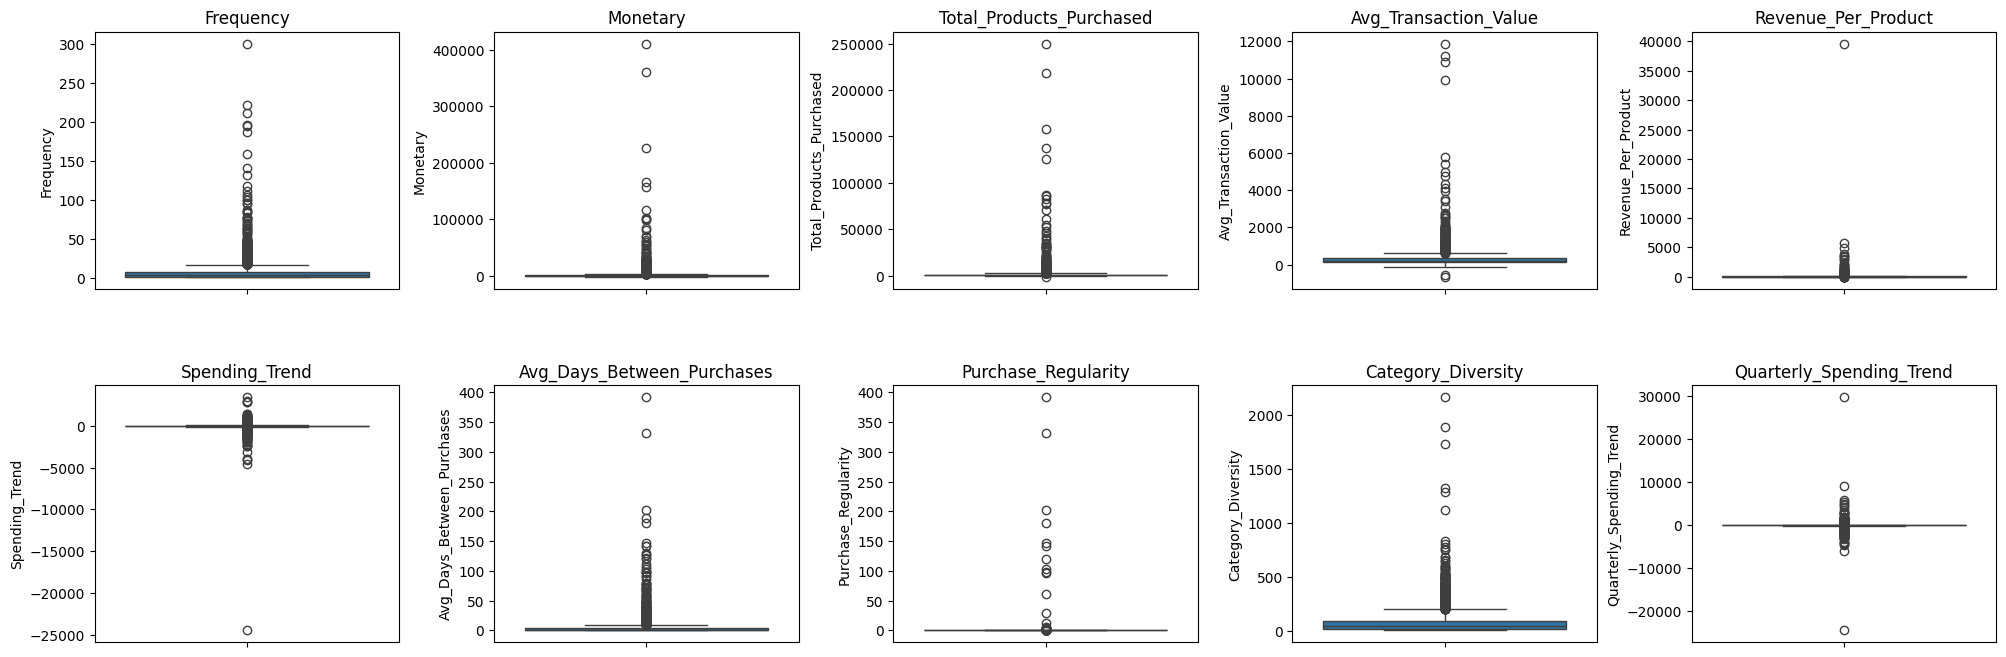

In [ ]:
selected_cols = customer_data[['Frequency', 'Monetary', 'Total_Products_Purchased', 'Avg_Transaction_Value', 'Revenue_Per_Product','Spending_Trend', 'Avg_Days_Between_Purchases', 'Purchase_Regularity', 'Category_Diversity', 'Quarterly_Spending_Trend']]

fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(20, 10))
ax = ax.flatten()

index = 0
for col in selected_cols.columns:
    sns.boxplot(y=col, data=selected_cols, ax=ax[index])
    ax[index].set_title(f"{col}")
    index += 1


for j in range(index, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)
plt.show()

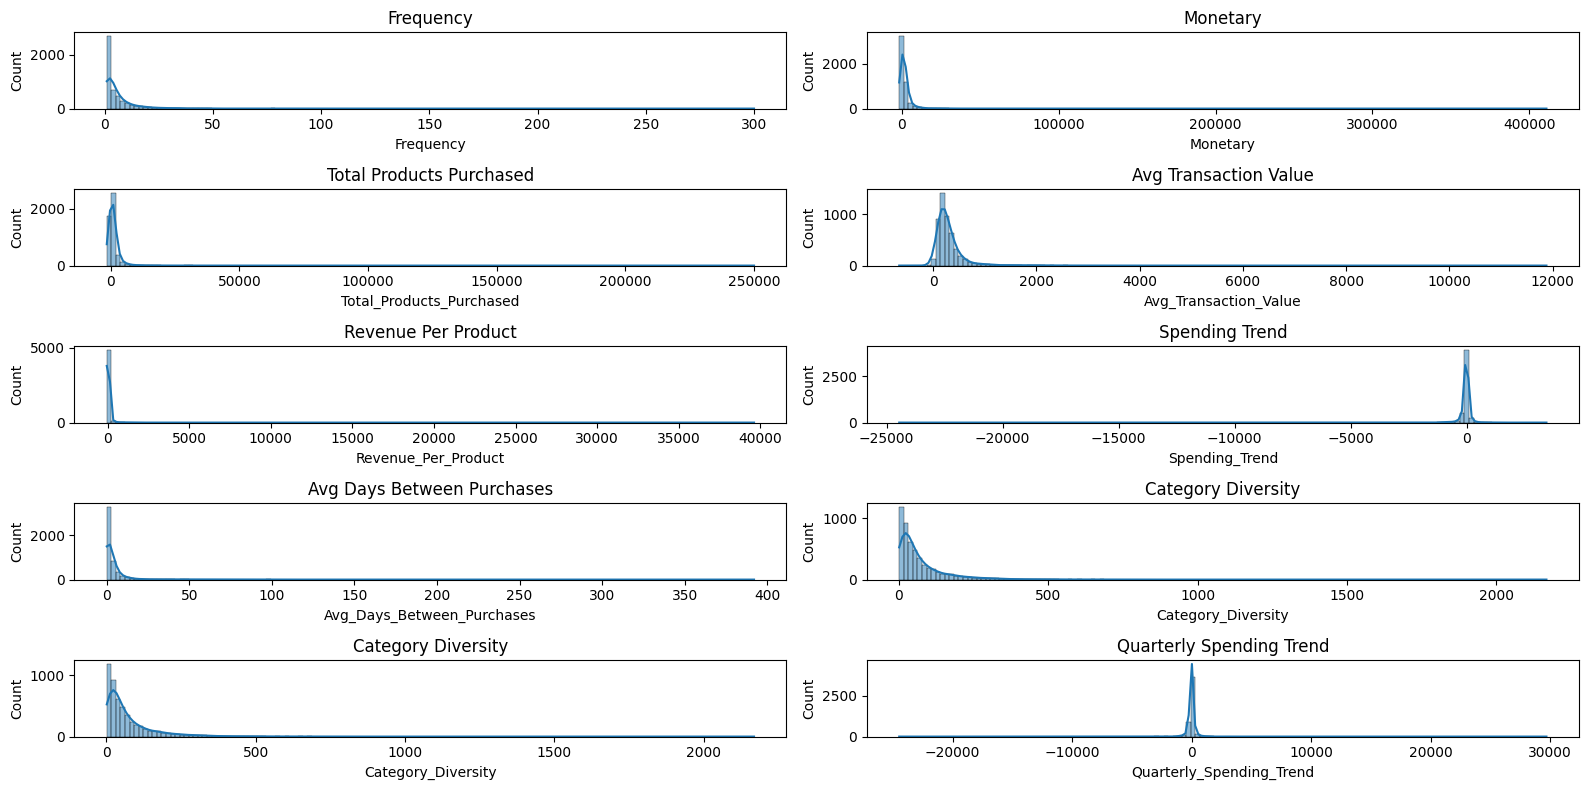

In [ ]:
plt.figure(figsize=(16, 8))




plt.subplot(5, 2, 1)
sns.histplot(customer_data['Frequency'], kde=True)
plt.title('Frequency')

plt.subplot(5, 2, 2)
sns.histplot(customer_data['Monetary'], kde=True)
plt.title('Monetary')

plt.subplot(5, 2, 3)
sns.histplot(customer_data['Total_Products_Purchased'], kde=True)
plt.title('Total Products Purchased')

plt.subplot(5, 2, 4)
sns.histplot(customer_data['Avg_Transaction_Value'], kde=True)
plt.title('Avg Transaction Value')

plt.subplot(5, 2, 5)
sns.histplot(customer_data['Revenue_Per_Product'], kde=True)
plt.title('Revenue Per Product')

plt.subplot(5, 2, 6)
sns.histplot(customer_data['Spending_Trend'], kde=True)
plt.title('Spending Trend')


plt.subplot(5, 2, 7)
sns.histplot(customer_data['Avg_Days_Between_Purchases'], kde=True)
plt.title('Avg Days Between Purchases')

plt.subplot(5, 2, 8)
sns.histplot(customer_data['Category_Diversity'], kde=True)
plt.title('Category Diversity')

plt.subplot(5, 2, 9)
sns.histplot(customer_data['Category_Diversity'], kde=True)
plt.title('Category Diversity')


plt.subplot(5, 2, 10)
sns.histplot(customer_data['Quarterly_Spending_Trend'], kde=True)
plt.title('Quarterly Spending Trend')



plt.tight_layout()
plt.show()

As per our analysis it was found that the Top 10 % customers contribute to the 50 % revenue and outliers which we are seeing is not error its insights of the business. So removing outliers is not recommended. Let's just handle the negative values only. 

In [ ]:
negative_columns = ['Monetary', 'Avg_Transaction_Value', 'Spending_Trend', 'Revenue_Per_Product']

negative_summary = {}

for col in negative_columns:
    negative_count = (customer_data[col] < 0).sum()
    negative_percentage = (negative_count / len(customer_data)) * 100
    
    if negative_count > 0:
        negative_values = customer_data[customer_data[col] < 0][col]
        negative_summary[col] = {
            'count': negative_count,
            'percentage': negative_percentage,
            'min_value': negative_values.min(),
            'max_value': negative_values.max(),
            'mean_value': negative_values.mean()
        }

print("\nNegative Values Found:\n")
for col, stats in negative_summary.items():
    print(f"{col}:")
    print(f"  Count: {stats['count']} ({stats['percentage']:.2f}%)")
    print(f"  Range: {stats['min_value']:.2f} to {stats['max_value']:.2f}")
    print(f"  Mean: {stats['mean_value']:.2f}\n")


Negative Values Found:

Monetary:
  Count: 28 (0.56%)
  Range: -1663.06 to -0.00
  Mean: -117.43

Avg_Transaction_Value:
  Count: 28 (0.56%)
  Range: -658.63 to -0.00
  Mean: -69.56

Spending_Trend:
  Count: 1997 (40.13%)
  Range: -24460.90 to -0.01
  Mean: -156.21

Revenue_Per_Product:
  Count: 28 (0.56%)
  Range: -54.00 to -0.00
  Mean: -15.57



All the negative values are contributed by Monetary feature due to cancellations or refund. We can just filter out  and clean the data.

In [ ]:
df_clean = customer_data[customer_data['Monetary'] >= 0].copy()

This removes only 28 customers but keeps all 2,413 declining spending signals

In [ ]:
df_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer ID,4948.0,15348.018391,1702.180266,12346.000000,13889.750000,15350.500000,16823.250000,18287.000000
Frequency,4948.0,6.377526,12.191259,1.000000,1.000000,3.000000,7.000000,300.000000
Monetary,4948.0,2315.993395,10477.445428,0.000000,307.512500,731.080000,1876.342500,410880.970000
Total_Products_Purchased,4948.0,1436.374495,7109.498335,0.000000,161.000000,407.500000,1076.000000,249995.000000
Unique_Products_Purchased,4948.0,71.078213,98.452751,1.000000,17.000000,40.000000,88.000000,2019.000000
Avg_Transaction_Value,4948.0,309.403090,435.788547,0.000000,150.973750,228.026667,352.350625,11880.840000
Customer_Tenure_Days,4948.0,367.162086,158.587111,0.000000,241.000000,403.000000,506.000000,558.000000
Revenue_Per_Product,4948.0,55.585775,595.376001,0.000000,13.412316,19.043636,30.617557,39619.500000
Avg_Days_Between_Purchases,4948.0,4.136478,12.871217,0.000000,0.000000,1.546050,3.893327,392.000000
Purchase_Regularity,4948.0,0.526380,9.290876,0.000000,0.000000,0.133531,0.193195,392.000000


We now have clean dataset and all the features are numeric so we don't need to do any other transformation. We shall not split the data. 

## Train - Test Split 

In [ ]:
from sklearn.model_selection import train_test_split
y = df_clean['Churn']
X = df_clean.drop(columns=['Churn'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)


## Standard Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Baseline Model 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

log_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
log_model.fit(X_train_scaled, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:

In [ ]:
y_pred = log_model.predict(X_test_scaled)
y_pred_proba = log_model.predict_proba(X_test_scaled)[:, 1]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix



print("Accuracy:", log_model.score(X_test_scaled, y_test))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8080808080808081
ROC-AUC: 0.8744648848779359

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.80      0.76       387
           1       0.86      0.82      0.84       603

    accuracy                           0.81       990
   macro avg       0.80      0.81      0.80       990
weighted avg       0.81      0.81      0.81       990


Confusion Matrix:
 [[308  79]
 [111 492]]


The Model achieves 81% accuracy with an ROC-AUC of 0.87, indicating good discriminative ability between classes. Confusion matrix indicated it misclassifies 79 negative cases as positive (false positives) and 111 positive cases as negative (false negatives). 

## Training with XGBoost

In [ ]:

import xgboost as xgb


xgb_params = {
    'max_depth': 3,
    'learning_rate': 0.1,   
    'n_estimators': 300,
    'subsample': 0.7,
    'colsample_bytree': 1.0,
    'min_child_weight': 1,
    'random_state': 42  }

xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]


In [ ]:
print("Accuracy:", xgb_model.score(X_test, y_test))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

Accuracy: 0.9242424242424242
ROC-AUC: 0.9750001071301546

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90       387
           1       0.95      0.93      0.94       603

    accuracy                           0.92       990
   macro avg       0.92      0.92      0.92       990
weighted avg       0.92      0.92      0.92       990


Confusion Matrix:
 [[356  31]
 [ 44 559]]


In [ ]:

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
                       Feature  Importance
1                    Frequency    0.196401
6         Customer_Tenure_Days    0.138177
2                     Monetary    0.098562
8   Avg_Days_Between_Purchases    0.084241
11          Category_Diversity    0.068132
3     Total_Products_Purchased    0.067538
4    Unique_Products_Purchased    0.056378
15           Cancellation_Rate    0.040887
12    Quarterly_Spending_Trend    0.040575
10   Top_Product_Concentration    0.038022


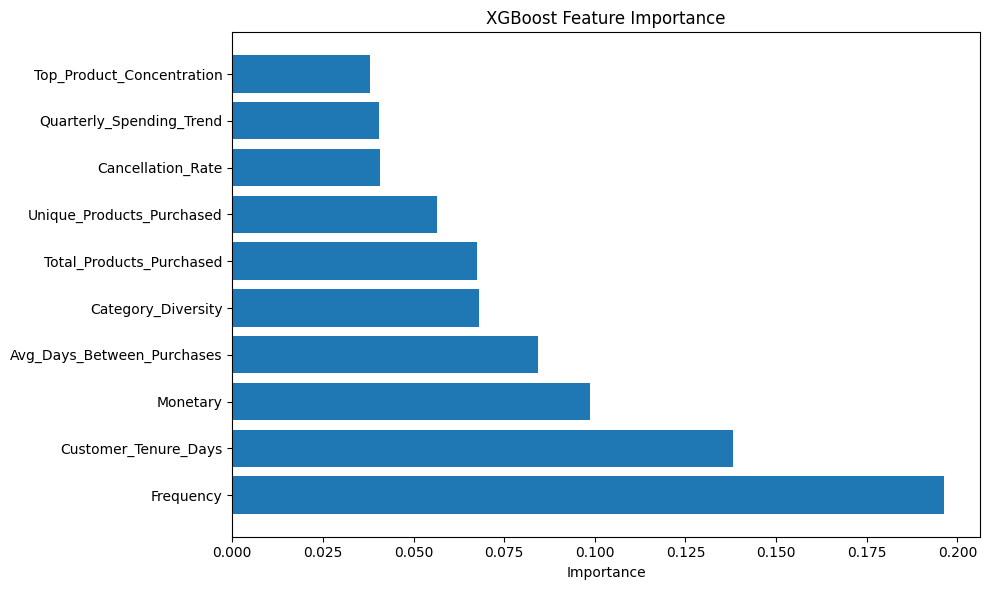

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'].head(10), feature_importance['Importance'].head(10))
plt.xlabel('Importance')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()


## Neural Network 

In [ ]:
X_train.shape

(3958, 17)

In [ ]:

import tensorflow as tf
from tensorflow import keras


model = keras.Sequential([
    keras.Input(shape=(17,)),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC()]
)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)